In [196]:
import time as tt
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

from utils import get_track

## First, start by defining the paramters

In [197]:
# Flattened NFW halo
logM, Rs, q = 12.0, 25.0, 0.8
dirx, diry, dirz = 1.0, 1.0, 1.0

# Plummer Sattelite
logm, rs = 8.0, 2.0 

# Initial conditions
x0, y0, z0 = 100.0, 0.0, 0.0     # Position in kpc
vx0, vy0, vz0 = 0.0, 200.0, 0.0  # Velocity in km/s

# Integration time
time = 3.0 # Gyr
alpha = 1.05

params = (logM, Rs, q, dirx, diry, dirz, logm, rs, x0, y0, z0, vx0, vy0, vz0, time, alpha)

n_steps = 500 # Number of steps in the time integration
n_particles = 10000 # Number of particles in the stream

## (1) Spray Method

In [141]:
from models import generate_stream_spray

start = tt.time()
theta_stream, xv_stream = generate_stream_spray(params,  seed=111, n_steps=n_steps, n_particles=n_particles)
end = tt.time()
print(f"Time taken to generate stream using Spray: {end - start:.2f} seconds")
count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1])

/Users/davidchemaly/miniforge3/envs/Astro/lib/python3.10/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(
/Users/davidchemaly/miniforge3/envs/Astro/lib/python3.10/site-packages/jax/_src/core.py:691: FutureWarning: unhashable type: <class 'jax._src.interpreters.partial_eval.DynamicJaxprTracer'>. Attempting to hash a tracer will lead to an error in a future JAX release.
  warnings.warn(


Time taken to generate stream using Spray: 3.00 seconds


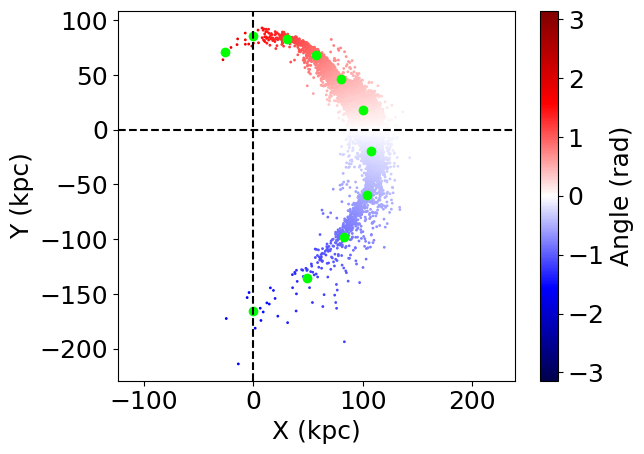

In [142]:
plt.scatter(xv_stream[:, 0], xv_stream[:, 1], c=theta_stream, s=1, cmap='seismic', vmin=-np.pi, vmax=np.pi)
plt.colorbar(label='Angle (rad)')
plt.scatter(r_bin*np.cos(theta_bin), r_bin*np.sin(theta_bin), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

## (2) Streak Method

In [ ]:
from models import generate_stream_streak

start = tt.time()
theta_stream, xv_stream = generate_stream_streak(params,  seed=111, n_steps=n_steps, n_particles=n_particles)
end = tt.time()
print(f"Time taken to generate stream using Streak: {end - start:.2f} seconds")
count, theta_bin, r_bin, w_bin = get_track(theta_stream, xv_stream[:, 0], xv_stream[:, 1])

Time taken to generate stream using Spray: 0.17 seconds


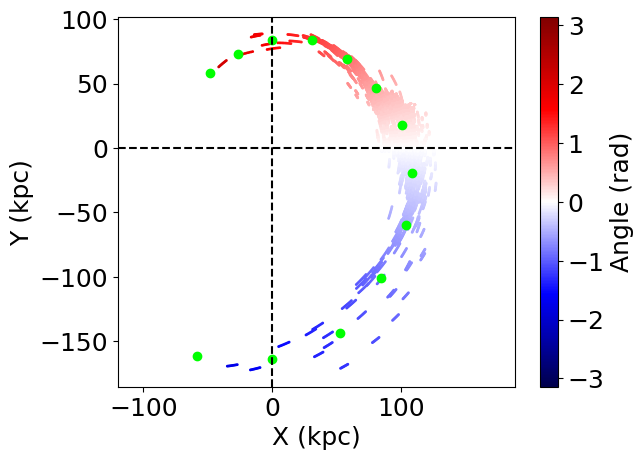

In [44]:
plt.scatter(xv_stream[:, 0], xv_stream[:, 1], c=theta_stream, s=1, cmap='seismic', vmin=-np.pi, vmax=np.pi)
plt.colorbar(label='Angle (rad)')
plt.scatter(r_bin*np.cos(theta_bin), r_bin*np.sin(theta_bin), c='lime')
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

## (3) Binned method

In [198]:
from integrants import integrate_satellite
from potentials import NFWHessian
from utils import get_rj_vj_R, create_ic_particle_spray, jax_unwrap

import jax
import jax.numpy as jnp

backward_trajectory = integrate_satellite(x0, y0, z0, vx0, vy0, vz0, logM, Rs, q, dirx, diry, dirz, -time, n_steps)

forward_trajectory  = integrate_satellite(*backward_trajectory[-1, :], logM, Rs, q, dirx, diry, dirz, time*alpha, n_steps)

theta_sat_forward = jnp.arctan2(forward_trajectory[:, 1], forward_trajectory[:, 0])
theta_sat_forward = jnp.where(theta_sat_forward < 0, theta_sat_forward + 2 * jnp.pi, theta_sat_forward)
theta_sat_forward = jax_unwrap(theta_sat_forward)

hessians  = jax.vmap(NFWHessian, in_axes=(0, 0, 0, None, None, None, None, None, None)) \
                    (forward_trajectory[:, 0], forward_trajectory[:, 1], forward_trajectory[:, 2], logM, Rs, q, dirx, diry, dirz)
rj, vj, R = get_rj_vj_R(hessians, forward_trajectory, 10 ** logm)
ic_particle_spray = create_ic_particle_spray(forward_trajectory, rj, vj, R, 0, 111, n_particles, n_steps)

index = jnp.repeat(jnp.arange(0, n_steps, 1), n_particles // n_steps)

In [199]:
from integrants import leapfrog_combined_step
from tqdm import tqdm

In [ ]:
r_threshold = 2.0*jnp.max(rj)

dt = time/n_steps
state0 = jnp.concatenate([ic_particle_spray, jnp.repeat(forward_trajectory, n_particles//n_steps, axis=0)], axis=1)

nb_bined = []
state = jnp.zeros_like(state0) * jnp.nan
state = state.at[:n_particles//n_steps].set(state0[:n_particles//n_steps])
count = jnp.zeros(state.shape[0])
for i in tqdm(range(n_steps), leave=True):
    state = jax.vmap(leapfrog_combined_step, in_axes=(0, None, None, None, None, None, None, None, None, None)) \
                        (state, dt, logM, Rs, q, dirx, diry, dirz, logm, rs)
    
    state_here = jnp.stack(state).T[:(n_particles//n_steps)*(i+1)]
    count_here = count[:(n_particles//n_steps)*(i+1)]

    r_here = jnp.sqrt( (state_here[:, 0] - state_here[:, 6])**2 + 
                        (state_here[:, 1] - state_here[:, 7])**2 + 
                        (state_here[:, 2] - state_here[:, 8])**2)

    arg_bin = jnp.where( (r_here > r_threshold) & (count_here == 0))[0]
    nb_bined.append(arg_bin.size)

    state_next = state0[(n_particles//n_steps)*(i+1):(n_particles//n_steps)*(i+2)]
    state = jnp.stack(state).T.at[:(n_particles//n_steps)*(i+2)].set(jnp.concatenate([state_here, state_next]))

    if arg_bin.size == 1:
        count = count.at[arg_bin[0]].set(1)
    elif arg_bin.size > 1:
        state = state.at[arg_bin[0]].set(jnp.median(state_here[arg_bin], axis=0))
        state = state.at[arg_bin[1:]].set(jnp.nan)

        count = count.at[arg_bin[0]].set(arg_bin.size)
        count = count.at[arg_bin[1:]].set(jnp.nan)

100%|██████████| 500/500 [03:04<00:00,  2.71it/s]


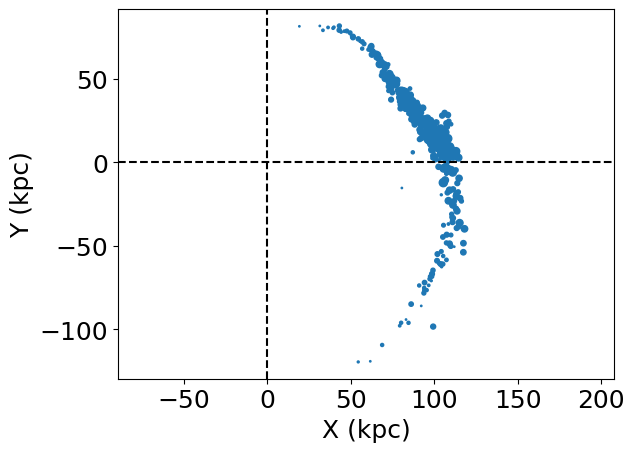

In [242]:
plt.scatter(state[:, 0], state[:, 1], s=count)
plt.axvline(0, color='k', linestyle='--')
plt.axhline(0, color='k', linestyle='--')
plt.xlabel('X (kpc)')
plt.ylabel('Y (kpc)')
plt.axis('equal');

## (4) 2nd Degree method